# Demo for performing PCA on sampled data sets

In this notebook we present how *PCA* can be performed on sampled data sets using the `reduction` module.

### PCA on sampled data set

A data set representing combustion of syngas in air generated from steady laminar flamelet model is used as a demo data set. We present a workflow for performing cluster-biased PCA on that data set using available functions:

- Visualizing data set centers movement
- Equilibrating cluster populations
- Visualizing eigenvector weights movement
- Visualizing eigenvalue distribution
- Performing re-sampling at equilibration until clustering convergence is reached

***

In [1]:
from PCAfold import preprocess
from PCAfold import reduction
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Set some initial parameters:
scal_crit = 'auto'
biasing_option = 2
n_clusters = 4
n_components = 2
save_plots = False
title = 'Demo run'

# Upload the sample data set:
state_space = pd.read_csv('data-state-space.csv', sep = ',', header=None).to_numpy()
source_state_space = pd.read_csv('data-state-space-sources.csv', sep = ',', header=None).to_numpy()
state_space_names = ['T', 'H2', 'O2', 'O', 'OH', 'H2O', 'H', 'HO2', 'CO', 'CO2', 'HCO']

We start with clustering the data set that will result in an `idx` vector. Clustering can be performed with any technique of choice. Here we will use K-Means clustering:

In [2]:
scaler = StandardScaler()
conditioning_variable = scaler.fit_transform(state_space)
kmeans = KMeans(n_clusters=n_clusters).fit(conditioning_variable)
idx = kmeans.labels_

***

## Run cluster equilibration

Notice that with `verbose=True` the function prints out the current number of samples taken from each cluster at each iteration.

In [3]:
(eigenvalues, eigenvectors, pc_scores, pc_sources, idx_train, X_center, X_scale) = reduction.equilibrate_cluster_populations(state_space, idx, scaling=scal_crit, X_source=source_state_space, n_components=n_components, biasing_option=biasing_option, n_iterations=10, stop_iter=0, verbose=True)

Biasing is performed with option 2.

At iteration 1 taking samples:
{0: 15748, 1: 5311, 2: 7579, 3: 18488}

At iteration 2 taking samples:
{0: 14589, 1: 5311, 2: 7328, 3: 17024}

At iteration 3 taking samples:
{0: 13430, 1: 5311, 2: 7077, 3: 15560}

At iteration 4 taking samples:
{0: 12271, 1: 5311, 2: 6826, 3: 14096}

At iteration 5 taking samples:
{0: 11112, 1: 5311, 2: 6575, 3: 12632}

At iteration 6 taking samples:
{0: 9953, 1: 5311, 2: 6324, 3: 11168}

At iteration 7 taking samples:
{0: 8794, 1: 5311, 2: 6073, 3: 9704}

At iteration 8 taking samples:
{0: 7635, 1: 5311, 2: 5822, 3: 8240}

At iteration 9 taking samples:
{0: 6476, 1: 5311, 2: 5571, 3: 6776}

At iteration 10 taking samples:
{0: 5311, 1: 5311, 2: 5311, 3: 5311}


***

## Centers movement

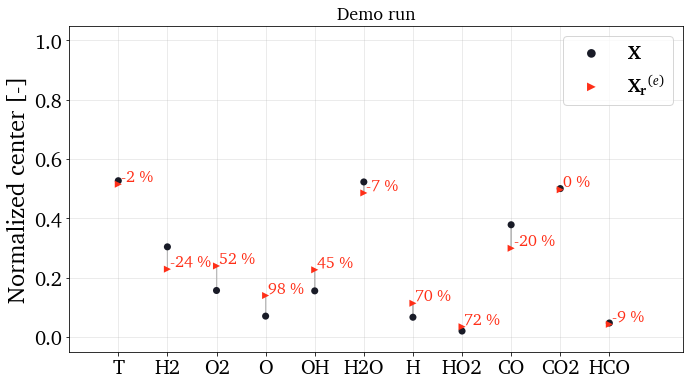

In [4]:
(centers_X, centers_X_r, perc) = reduction.analyze_centers_movement(state_space, idx_train, variable_names=state_space_names, title=title, save_filename=None)

***

## Eigenvector weights movement

We are going to plot the first eigenvector (PC-1) weights movement with three variants of normalization. To access the first eigenvector one can simply do:

```python
eigenvectors[:,0,:]
```

similarly, to access the second eigenvector:

```python
eigenvectors[:,1,:]
```

and so on.

Let's start with no normalization `normalize=False`:

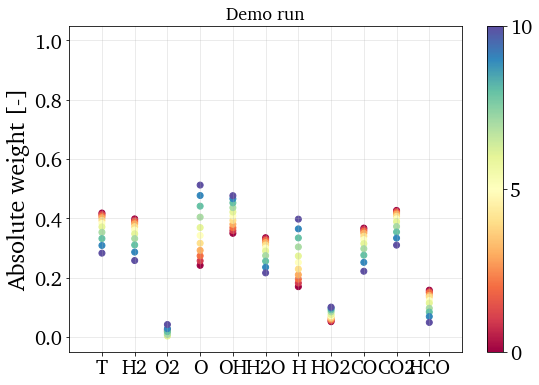

In [5]:
reduction.analyze_eigenvector_weights_movement(eigenvectors[:,0,:], state_space_names, plot_variables=[], normalize=False, zero_norm=False, title=title, save_filename='../images/documentation-plot-non-normalized')

Normalization with `normalize=True` and `zero_norm=False`:

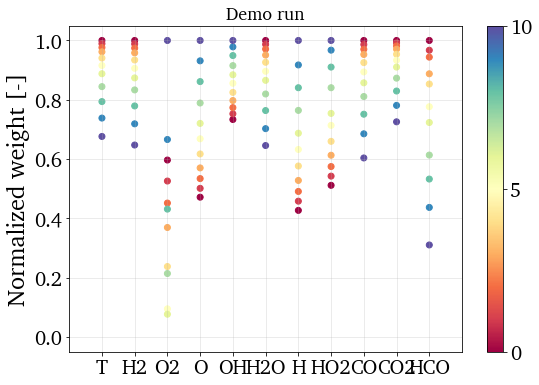

In [6]:
reduction.analyze_eigenvector_weights_movement(eigenvectors[:,0,:], state_space_names, plot_variables=[], normalize=True, zero_norm=False, title=title, save_filename='../images/documentation-plot-normalized')

Normalization with `normalize=True` and `zero_norm=True`:

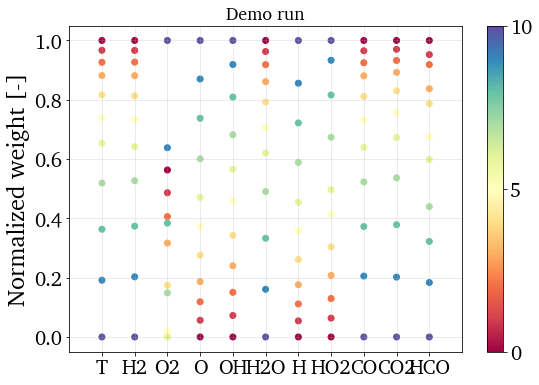

In [7]:
reduction.analyze_eigenvector_weights_movement(eigenvectors[:,0,:], state_space_names, plot_variables=[], normalize=True, zero_norm=True, title=title, save_filename='../images/documentation-plot-normalized-to-zero')

Note that in the above example the color bar marks the iteration number and so the $0^{th}$ iteration represents eigenvectors from the initial data set *(as-is)*. The last iteration, in this example $10^{th}$, represents eigenvectors computed on the *equilibrated* data set.

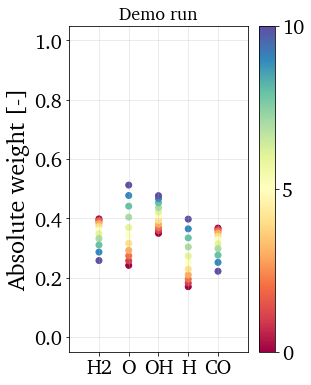

In [8]:
reduction.analyze_eigenvector_weights_movement(eigenvectors[:,0,:], state_space_names, plot_variables=[1,3,4,6,8], normalize=False, zero_norm=False, title=title, save_filename='')